# Stock Market Anomaly Detection Using Machine Learning

## 1. Problem Statement
The objective of this project is to detect abnormal movements in stock market prices,
such as sudden spikes, crashes, and unusual volatility, using statistical and machine
learning–based anomaly detection techniques on time-series data.

## 2. Data Collection
In this section, historical stock price data is collected using the Yahoo Finance API.

## 3. Data Preprocessing
This step includes selecting relevant features, handling missing values, and ensuring
the data is suitable for time-series analysis.

## 4. Feature Engineering
Additional financial features such as daily returns and rolling volatility are created
to enhance anomaly detection performance.

## 5. Anomaly Detection Models

### 5.1 Z-Score Method
A statistical approach to identify anomalies based on standard deviation from the mean.

### 5.2 Isolation Forest
A tree-based unsupervised machine learning model effective for high-dimensional data.

### 5.3 Local Outlier Factor (LOF)
A density-based anomaly detection method that captures local deviations in data.

## 6. Results & Comparison
The performance of different anomaly detection techniques is compared using visual
inspection and anomaly counts.

## 7. Conclusion & Future Work
Key findings are summarized, and possible improvements such as deep learning-based
approaches are discussed.

In [1]:
pip install yfinance


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import zscore

plt.style.use("seaborn-v0_8")

In [3]:
ticker = "AAPL"
data = yf.download(ticker, start="2018-01-01", end="2024-01-01")

data.head()


/tmp/ipython-input-3984276427.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2018-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.341881,40.351250,39.639305,39.850080,102223600
2018-01-03,40.334873,40.878200,40.271644,40.405131,118071600
2018-01-04,40.522213,40.625258,40.299731,40.407458,89738400
2018-01-05,40.983578,41.070228,40.526904,40.618239,94640000
2018-01-08,40.831352,41.126433,40.732989,40.831352,82271200


In [4]:
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.dropna(inplace=True)

data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2018-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Open, AAPL)    1509 non-null   float64
 1   (High, AAPL)    1509 non-null   float64
 2   (Low, AAPL)     1509 non-null   float64
 3   (Close, AAPL)   1509 non-null   float64
 4   (Volume, AAPL)  1509 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.7 KB


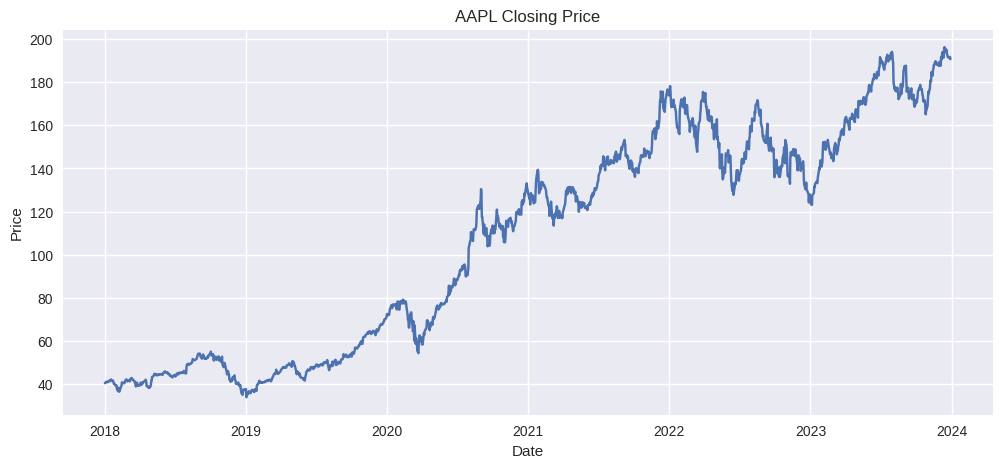

In [5]:
plt.figure(figsize=(12,5))
plt.plot(data.index, data['Close'])
plt.title(f"{ticker} Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


In [6]:
print(data.columns)


MultiIndex([(  'Open', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            ( 'Close', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [7]:
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)


In [8]:
print(data.columns)


Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object', name='Price')


In [9]:
data['Daily_Return'] = data['Close'].pct_change()

data['Rolling_Mean_20'] = data['Close'].rolling(window=20).mean()
data['Rolling_Std_20'] = data['Close'].rolling(window=20).std()

data.dropna(inplace=True)


In [10]:
data[['Close', 'Daily_Return', 'Rolling_Std_20']].head()


Price,Close,Daily_Return,Rolling_Std_20
Date,,,
2018-01-30,39.103027,-0.005894,0.786846
2018-01-31,39.210743,0.002755,0.860775
2018-02-01,39.292706,0.002090,0.918199
2018-02-02,37.587788,-0.043390,1.155161
2018-02-05,36.648689,-0.024984,1.444388


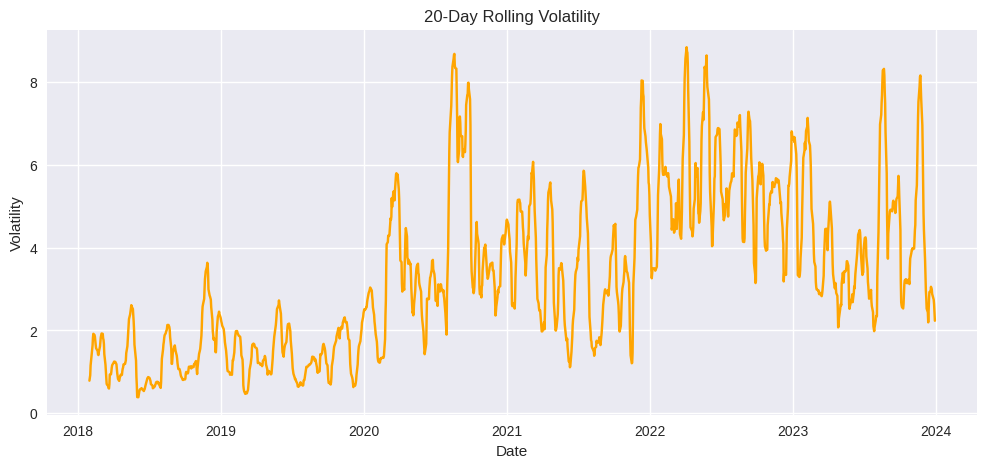

In [11]:
plt.figure(figsize=(12,5))
plt.plot(data.index, data['Rolling_Std_20'], color='orange')
plt.title("20-Day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()


In [12]:
from scipy.stats import zscore

data['Z_Score'] = zscore(data['Daily_Return'])
data['z_Anomaly']=np.abs(data['Z_Score'])>3

In [13]:
data['Z_Score'] = zscore(data['Daily_Return'].values)
data['Z_Anomaly'] = (np.abs(data['Z_Score']) > 3)


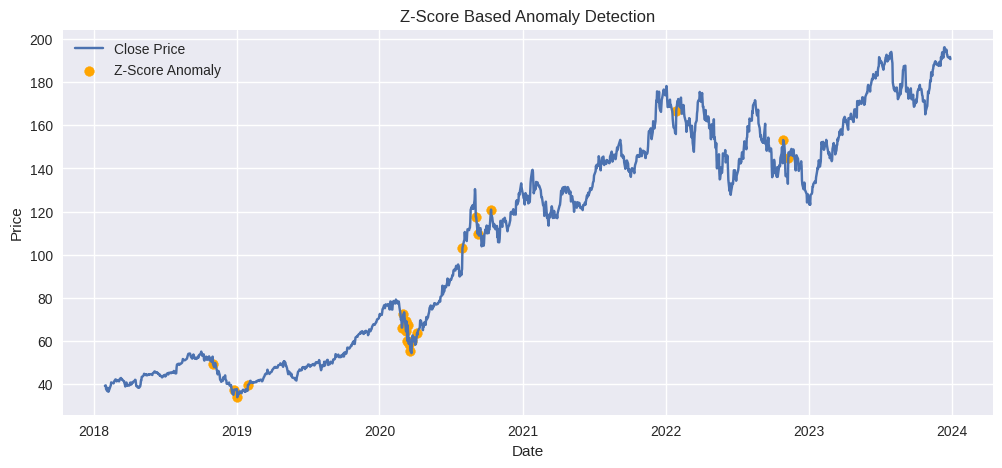

In [14]:
plt.figure(figsize=(12,5))
plt.plot(data.index, data['Close'], label='Close Price')

anomalies = data.loc[data['Z_Anomaly']]

plt.scatter(
    anomalies.index,
    anomalies['Close'],
    color='orange',
    label='Z-Score Anomaly'
)

plt.legend()
plt.title("Z-Score Based Anomaly Detection")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


In [15]:
print(data.columns)
print(data['Z_Anomaly'].dtype)


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return',
       'Rolling_Mean_20', 'Rolling_Std_20', 'Z_Score', 'z_Anomaly',
       'Z_Anomaly'],
      dtype='object', name='Price')
bool


In [16]:
featured=data[['Daily_Return','Rolling_Std_20','Volume']]

In [17]:
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)

data['IF_Anomaly'] = iso_forest.fit_predict(featured)
data['IF_Anomaly'] = data['IF_Anomaly'] == -1

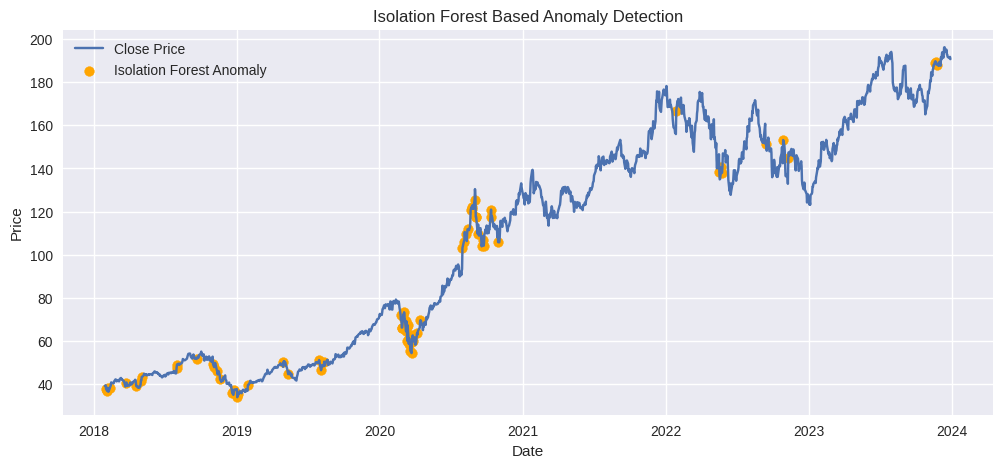

In [18]:
plt.figure(figsize=(12,5))
plt.plot(data.index, data['Close'], label='Close Price')

anomalies = data.loc[data['IF_Anomaly']]

plt.scatter(
    anomalies.index,
    anomalies['Close'],
    color='orange',
    label='Isolation Forest Anomaly'
)

plt.legend()
plt.title("Isolation Forest Based Anomaly Detection")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


In [19]:
print("Isolation Forest anomalies detected:", data['IF_Anomaly'].sum())


Isolation Forest anomalies detected: 75


In [20]:
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.05,

)
data['LOF_Anomaly'] = lof.fit_predict(featured)
data['LOF_Anomaly'] = data['LOF_Anomaly'] == -1

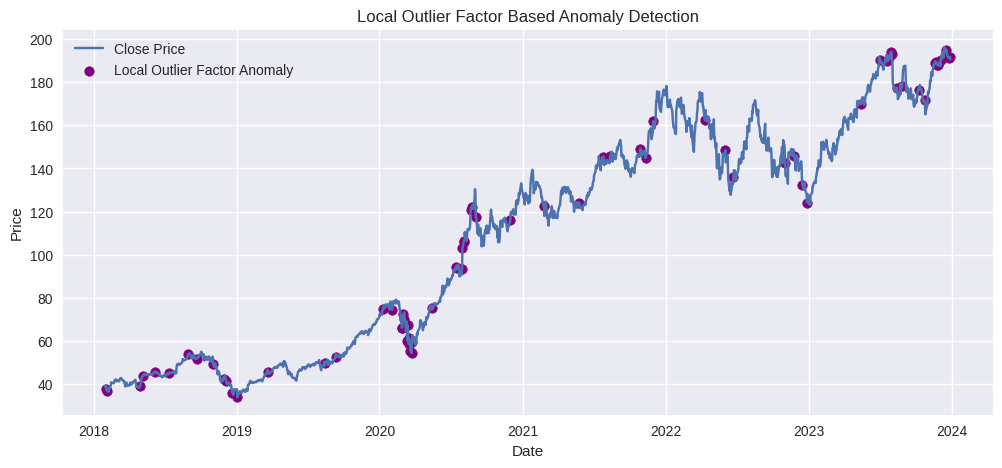

In [21]:
plt.figure(figsize=(12,5))
plt.plot(data.index, data['Close'], label='Close Price')

anomalies = data.loc[data['LOF_Anomaly']]

plt.scatter(
    anomalies.index,
    anomalies['Close'],
    color='purple',
    label='Local Outlier Factor Anomaly'
)

plt.legend()
plt.title("Local Outlier Factor Based Anomaly Detection")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [22]:
print("LOF anomalies detected:", data['LOF_Anomaly'].sum())


LOF anomalies detected: 75


In [23]:
comaparison = pd.DataFrame({
    'Method': ['Z-Score', 'Isolation Forest', 'Local Outlier Factor'],
    'Anomaly Count': [
        data['Z_Anomaly'].sum(),
        data['IF_Anomaly'].sum(),
        data['LOF_Anomaly'].sum()
    ]
})

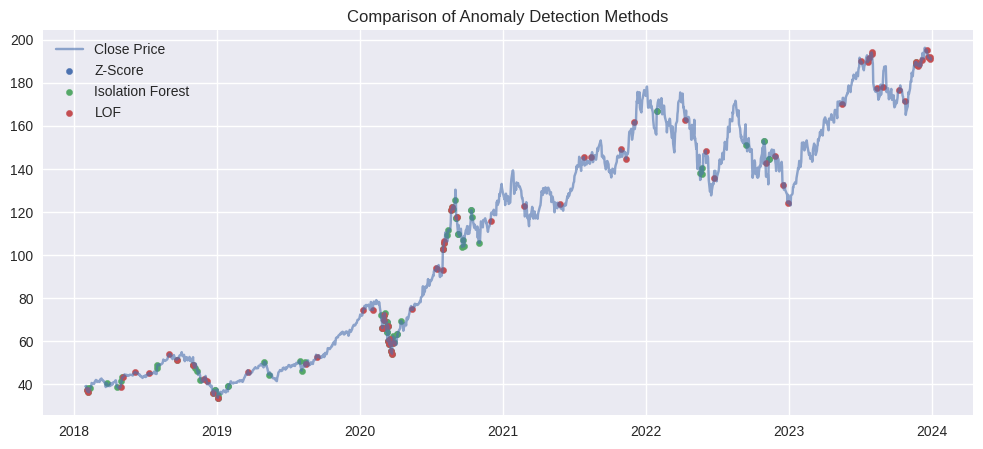

In [24]:
plt.figure(figsize=(12,5))
plt.plot(data.index, data['Close'], label='Close Price', alpha=0.6)

plt.scatter(data.loc[data['Z_Anomaly']].index,
            data.loc[data['Z_Anomaly']]['Close'],
            label='Z-Score', s=20)

plt.scatter(data.loc[data['IF_Anomaly']].index,
            data.loc[data['IF_Anomaly']]['Close'],
            label='Isolation Forest', s=20)

plt.scatter(data.loc[data['LOF_Anomaly']].index,
            data.loc[data['LOF_Anomaly']]['Close'],
            label='LOF', s=20)

plt.legend()
plt.title("Comparison of Anomaly Detection Methods")
plt.show()


Isolation Forest detected fewer but more significant anomalies compared to Z-score,
which was more sensitive to extreme values. LOF captured localized abnormal patterns
during volatile periods. Overall, Isolation Forest provided the best balance between
robustness and interpretability.


## Conclusion
This project explored multiple statistical and machine learning techniques for detecting
anomalies in stock market time-series data. Feature engineering played a critical role in
improving detection quality. Among the models, Isolation Forest demonstrated the most
robust performance.

## Future Work
- Extend to real-time anomaly detection
- Apply deep learning models such as autoencoders
- Test across multiple stocks and market conditions
